# Poprawa współczynników filtru 
---
<p align="center">
    <img src="./doc/img/FIR.png", width = "500px">
</p>

## Wyznaczanie parametrów filtru - metoda okna

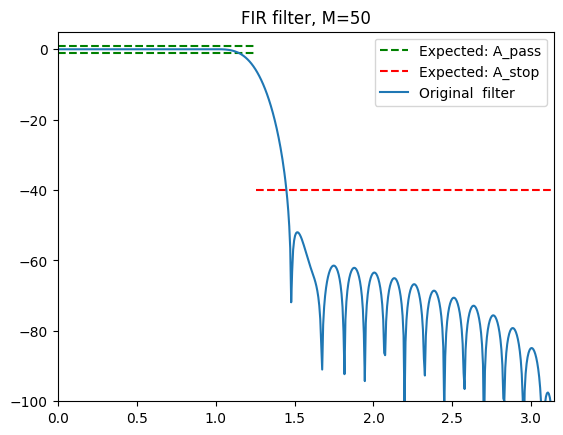

Initial value cost function: 61.323709036643486 


In [8]:
from filter import filter_utils
from scipy import signal
import numpy as np

# Parametry filtru
filter = {
    'N_fft':   512,
    'm_order': 50,
    'fs':      48e3,
    'f_pass':  9.6e3,
    'tr_band': 0.0e3,
    'd1_db':   1,
    'd2_db':   -40,
}

# Normalize filter
filter_n = filter_utils.normalize_filter (filter)

# Współczynniki filtru metoda okienkowa
coef     = signal.firwin(filter['m_order'], filter['f_pass'], fs=filter['fs'], window='hamming')
f, f_res = signal.freqz(coef, worN=filter['N_fft'])

# Wyświetlenie parametrów filtru
filter_utils.display_LP_filter(f[np.newaxis,:], f_res[np.newaxis,:], filter_n)

# Domyślna wartość funkcji kosztu
cost_val = filter_utils.cost_LP_filter(abs(f_res), filter_utils.db_to_linear(filter_n['d1_db'])-1, filter_utils.db_to_linear(filter_n['d2_db']), filter_n['f_pass'], filter_n['tr_band'])
print("Initial value cost function: {} ".format(cost_val))

## Poprawa współczynników filtru metoda RVNS

In [4]:
from filter import filter_utils
from filter import rvns_filter

cost_best, coef_best = rvns_filter.rvns_con(coef, filter_n)

## Uzyskane rezultaty 

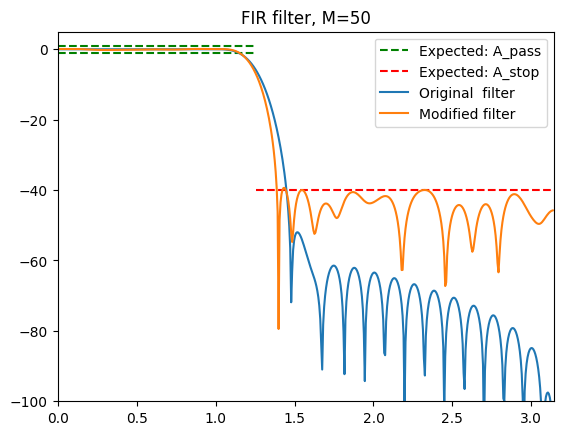

In [7]:
from filter import filter_utils
f_b, f_res_b = signal.freqz(coef_best, worN=filter_n['N_fft'])
filter_utils.display_LP_filter(np.append(f[np.newaxis,:], f_b[np.newaxis,:], axis=0), 
                                np.append(f_res[np.newaxis,:], f_res_b[np.newaxis,:], axis=0 ), filter_n)